In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langchain_community.tools import TavilySearchResults
from typing import TypedDict
import yfinance as yf
import re
import os
from dotenv import load_dotenv
load_dotenv()


True

In [2]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
tavali = TavilySearchResults()

C:\Users\sunda\AppData\Local\Temp\ipykernel_7444\2986204818.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavali = TavilySearchResults()


In [3]:
class AnalystState(TypedDict):
    input: str
    ticker: str
    financial_data: dict
    news_articles: list
    sentiment_summary: str
    risk_analysis: str
    recommendation: str

In [4]:
def parse_input(state:AnalystState) -> AnalystState:
    query = state["input"]
    ticker_match = re.search(r"[A-Z]{1,5}(\.NS)?", query)
    return {"ticker": ticker_match.group() if ticker_match else "AAPL"}

In [5]:
def fetch_financial_data(state:AnalystState) -> AnalystState:
    ticker = state["ticker"]
    stock = yf.Ticker(ticker)
    info = stock.info
    return {"financial_data": {
        "current_price": info.get("currentPrice"),
        "market_cap": info.get("marketCap"),
        "pe_ratio": info.get("trailingPE"),
        "sector": info.get("sector"),
        "name": info.get("shortName")
    }}

In [6]:
def fetch_news(state:AnalystState) -> AnalystState:
    name = state["financial_data"]["name"]
    results = tavali.run(f"{name} stock news")
    return {"news_articles": results}

In [7]:
def analyze_sentiment(state:AnalystState) -> AnalystState:
    llm_prompt = f"""
You are a financial sentiment analyst.

Analyze the following news snippets about {state['ticker']} and summarize overall market sentiment
as Positive, Negative, or Mixed. Then give a 2-sentence explanation.

News:
{[item['content'] for item in state['news_articles']]}

Answer:
"""


    result = llm.invoke(llm_prompt)
    return {"sentiment_summary": result.content}


In [8]:
def evaluate_risk(state:AnalystState) -> AnalystState:
    fd = state["financial_data"]
    prompt = f"""
Analyze the following financial data for risk level (Low, Moderate, High):

- Price: ₹{fd['current_price']}
- Market Cap: {fd['market_cap']}
- PE Ratio: {fd['pe_ratio']}
- Sector: {fd['sector']}

Answer in 2-3 sentences with a clear risk assessment.
"""
    result = llm.invoke(prompt)
    return {"risk_analysis": result.content}


In [9]:
def investment_recommendation(state:AnalystState) -> AnalystState:
    prompt = f"""
Based on the financials, sentiment, and risk, give a human-like investment recommendation for stock {state['ticker']}.

Financials:
{state['financial_data']}

Sentiment:
{state['sentiment_summary']}

Risk:
{state['risk_analysis']}

Your Answer (in plain English):
"""
    result = llm.invoke(prompt)
    return {"recommendation": result.content}


In [10]:
graph = StateGraph(AnalystState)

graph.add_node("parse_input",parse_input)
graph.add_node("fetch_financial_data",fetch_financial_data)
graph.add_node("fetch_news",fetch_news)
graph.add_node("analyze_sentiment",analyze_sentiment)
graph.add_node("evaluate_risk",evaluate_risk)
graph.add_node("investment_recommendation",investment_recommendation)

graph.add_edge(START,"parse_input")
graph.add_edge("parse_input","fetch_financial_data")
graph.add_edge("fetch_financial_data","fetch_news")
graph.add_edge("fetch_news","analyze_sentiment")
graph.add_edge("analyze_sentiment","evaluate_risk")
graph.add_edge("evaluate_risk","investment_recommendation")
graph.add_edge("investment_recommendation",END)

app = graph.compile()

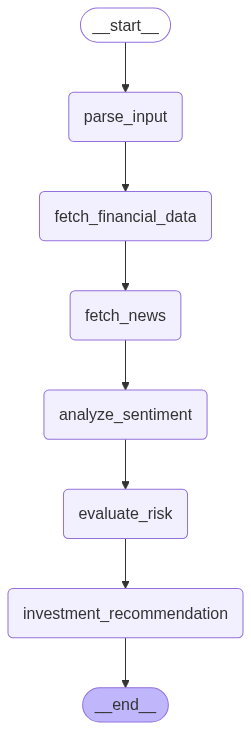

In [11]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
result = app.invoke({"input": "Should I invest in TCS?"})
l1 = ["input","financial_data","news_articles","sentiment_summary","risk_analysis","recommendation"]

for l in l1:
  print(f"\n\n -------------------------{l}------------------------\n\n")
  print(result[l])
  




 -------------------------input------------------------


Should I invest in TCS?


 -------------------------financial_data------------------------


{'current_price': 17.29, 'market_cap': 5748665856, 'pe_ratio': None, 'sector': 'Technology', 'name': 'SentinelOne, Inc.'}


 -------------------------news_articles------------------------


[{'title': 'SentinelOne, Inc. (S) Stock Forecast & Price Prediction 2025–2030', 'url': 'https://coincodex.com/stock/S/price-prediction/', 'content': "| Date | Prediction | Potential ROI |\n| --- | --- | --- |\n| Jul 13, 2025 | $â\x80¯17.29 | 0.00% Buy |\n| Jul 14, 2025 | $â\x80¯16.90 | 2.25% Short |\n| Jul 15, 2025 | $â\x80¯16.39 | 5.19% Short |\n| Jul 16, 2025 | $â\x80¯15.84 | 8.39% Short |\n| Jul 17, 2025 | $â\x80¯15.90 | 8.03% Short |\n\nOver the next five days, SentinelOne, Inc. will reach the highest price of $â\x80¯17.29 tomorrow, which would represent 0.00% growth compared to the current price. This follows a -6.29% price change over the last